K-Means Clustering of the census

In [28]:
import os
os.environ['OMP_NUM_THREADS'] = '10'

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np


In [29]:
DATA_PATH = "../data/1832_v4_preprocessed.csv"
df = pd.read_csv(DATA_PATH)
df.dtypes

nom_rue                  object
no_maison                 int64
chef_annee_naissance    float64
chef_origine             object
chef_annee_arrivee      float64
chef_vocation            object
page                      int64
division                  int64
chef_vocation_class      object
chef_origine_class       object
division_class           object
division_name            object
dtype: object

In [30]:
# Convert chef_origine and chef_vocation to categorical
df["chef_origine_class"] = df["chef_origine_class"].astype("category")
df["chef_vocation_class"] = df["chef_vocation_class"].astype("category")

df.dtypes

nom_rue                   object
no_maison                  int64
chef_annee_naissance     float64
chef_origine              object
chef_annee_arrivee       float64
chef_vocation             object
page                       int64
division                   int64
chef_vocation_class     category
chef_origine_class      category
division_class            object
division_name             object
dtype: object

In [31]:
# Check if there are nan values in those categorical columns
# Before dropping nans
df.shape[0]

3803

## K-Means

In [32]:
def get_df_cluster(df, n_clusters=18, permute=False):
    new_df = df.copy()

    # Permute the chef_origine and chef_vocation columns
    if permute:
        new_df["chef_origine_class"] = np.random.permutation(new_df["chef_origine_class"])
        new_df["chef_vocation_class"] = np.random.permutation(new_df["chef_vocation_class"])

    # Select only the columns we want to cluster
    df_cluster = new_df[["chef_origine_class", "chef_vocation_class", "division"]]

    # Drop nans
    df_cluster = df_cluster.dropna()
    df_cluster.shape[0]

    # Get the dummies
    df_cluster_dummies = pd.get_dummies(df_cluster)

    # Remove the division column as we want to predict it
    df_cluster_dummies = df_cluster_dummies.drop(columns=["division"])

    df_cluster_dummies.head()
    
    # Get the clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    kmeans.fit(df_cluster_dummies)
    cluster_labels = kmeans.predict(df_cluster_dummies)
    df_cluster["cluster"] = cluster_labels

    return df_cluster

def get_cluster_division_assignment(df_cluster):
    # Get the max count in each division
    df_cluster_class = df_cluster.groupby(['division', 'cluster']).size().reset_index(name="count")
    df_cluster_class_max = df_cluster_class.groupby(['division']).agg({'count': 'max'}).rename(columns={'count': 'max_count'}).reset_index()

    # Start with an empty dictionary to store cluster assignments
    division_cluster_assignment = {}
    assigned_clusters = set()

    # Get a set of all clusters
    all_clusters = set(df_cluster_class['cluster'])

    # Sort divisions by their maximum cluster count
    df_cluster_class_max.sort_values('max_count', ascending=False, inplace=True)

    # Go through divisions one by one
    for division in df_cluster_class_max['division']:
        # Get rows related to this division
        division_rows = df_cluster_class[df_cluster_class['division'] == division].copy()
        # Sort these rows by count
        division_rows.sort_values('count', ascending=False, inplace=True)

        # Go through clusters within this division, starting with the one with highest count
        for idx, row in division_rows.iterrows():
            # If this cluster is not yet assigned, assign it to this division and break the loop
            if row['cluster'] not in assigned_clusters:
                division_cluster_assignment[division] = row['cluster']
                assigned_clusters.add(row['cluster'])
                break
        # If all clusters are already assigned, assign this division to the cluster with lowest count that is not yet assigned
        else:
            for cluster in all_clusters:
                if cluster not in assigned_clusters:
                    division_cluster_assignment[division] = cluster
                    assigned_clusters.add(cluster)
                    break

    cluster_division_assignment = {v: k for k, v in division_cluster_assignment.items()}
    return cluster_division_assignment

def get_f1_score(df, permute=False):
    df_cluster = get_df_cluster(df, permute=permute)
    cluster_division_assignment = get_cluster_division_assignment(df_cluster)
    df_cluster['assigned_division'] = df_cluster['cluster'].map(cluster_division_assignment)

    return f1_score(df_cluster["division"], df_cluster["assigned_division"], average="weighted")

In [41]:
def permutation_test(df, n_runs=100, alpha=0.05):
    f1_scores = []
    original_f1 = get_f1_score(df, permute=False)

    for _ in tqdm(range(n_runs)):
        permuted_f1 = get_f1_score(df, permute=True)
        f1_scores.append(permuted_f1)

    # Calculate p-value
    p_value = np.sum(np.array(f1_scores) >= original_f1) / n_runs

    # Calculate confidence interval
    ci_lower, ci_upper = np.percentile(f1_scores, [(alpha/2)*100, (1-alpha/2)*100])

    return p_value, ci_lower, ci_upper, f1_scores

p_value, ci_lower, ci_upper, f1_scores = permutation_test(df, n_runs=100)

100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


In [43]:
print("P-value:", p_value)
print("95% Confidence Interval:", (ci_lower, ci_upper))

P-value: 0.0
95% Confidence Interval: (0.07822302062589051, 0.09691150859361229)


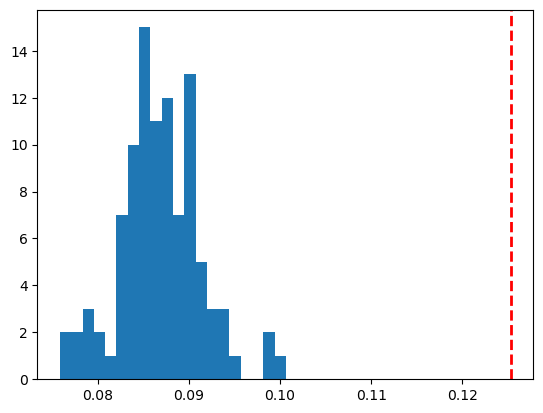

In [44]:
# plot f1_scores
plt.hist(f1_scores, bins=20)
# Add a vertical line at the original f1 score
original_f1 = get_f1_score(df, permute=False)
plt.axvline(x=original_f1, color='r', linestyle='dashed', linewidth=2)
plt.show()

## Agglomerative Clustering

In [63]:
# Now try AgglomerativeClustering
N_CLUSTERS = 18
agg = AgglomerativeClustering(n_clusters=N_CLUSTERS)
agg.fit(df_cluster_dummies)

cluster_labels = agg.labels_
cluster_labels

df_cluster["cluster_agg"] = cluster_labels
df_cluster.loc[0:50]

,chef_origine_class,chef_vocation_class,division,cluster,cluster_agg
1,rolle,artisanat,1,1,7
2,moudon,service,1,4,2
6,nyon,service,1,4,2
8,lausanne,rente,1,5,6
9,lausanne,rente,1,5,6
11,la_vallee,commerce,1,9,3
12,vaud,artisanat,1,1,4
14,cossonay,rente,1,16,0
15,cossonay,rente,1,16,0
16,lausanne,rente,1,5,6
